# 18.S190/6.S090 Problem Set 3

Due Friday 2/28 at **11:59pm**; 20% penalty if it is turned in within 24 hours, and after that late psets will not be accepted.   Submit in PDF format: a decent-quality scan/image of any handwritten solutions (e.g. get a scanner app on your phone or use a tablet), combined with a PDF printout of your Jupyter notebook showing your code and (clearly labeled) results.

## Problem 1 (2+4+4+4+3+3 points)

When interpolating polynomials from a "tensor product grid" in multiple dimensions, it turns out that you can get dramatically better efficiency by **interpolating along one dimension at a time**.  In this problem, you will investigate that process in two dimensions.

Suppose that we have an $(M+1) \times (N+1)$ grid of points $(x_m, y_m)$ (for $x_0, x_1, \ldots, x_M$ and $y_0, y_1, \ldots, y_N$), like the one shown below:

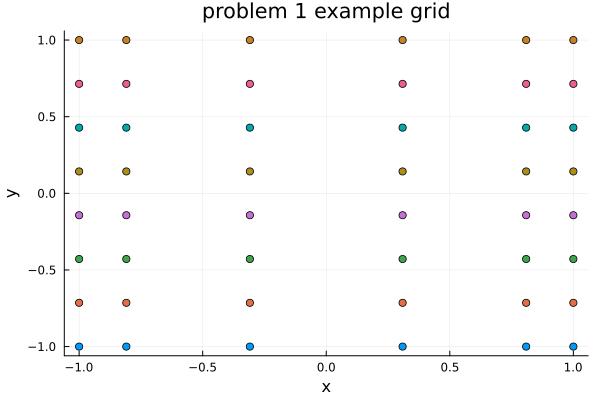

In [3]:
M, N = 5, 7
x = cos.(range(0, pi, length=M+1)) # Chebyshev grid in x
y = range(-1, 1, length=N+1) # equispaced grid in y
using Plots
scatter(x .* ones(N+1)', ones(M+1) .* y', title="problem 1 example grid", xlabel="x", ylabel="y", legend=false)

We have function values on this grid, $Z_{m,n} = f(x_m, y_n)$ for some function $f(x,y)$, which we store in an $(M+1) \times (N+1)$ matrix $Z$.

Now, we want to interpolate $Z$ with a two-variable polynomial
$$p(x,y) = \sum_{m=0}^{M} \sum_{n=0}^{N} C_{m,n} x^m y^n \, ,$$
for coefficients stored in an $(M+1) \times (N+1)$ matrix $C$, satisfying the interpolation conditions $p(x_m, y_n) = Z_{m,n}$.

**(a)** One way to solve for $C$ is to "flatten" or ["vectorize"](https://en.wikipedia.org/wiki/Vectorization_(mathematics) the unknown coefficients $C$ into a column vector $c$ (e.g. by `vec(C)` in Julia or equivalently `C.flatten('F')` in NumPy), and similarly vectorize $Z$ into a vector.   You then solve an equation $Ac = z$ for $c$, where $A$ is the Vandermonde matrix of all our basis functions $x^m y^n$.    If you solve this in the usual way (with Gaussian elimination / LU factorization), **how does the computational cost scale** with $M$ and $N$?  (i.e. $O(M^3 N^{17})$ or ....?  How big are $A$, $c$, and $z$?)

**(b)** Consider the case $M=N=1$ where you are just doing bilinear interpolation from 4 points, as in class.  **Show by explicit 2×2 multiplication** that polynomial interpolation corresponds to the matrix equation: 
$$
X C Y^T = Z
$$
where $X = \begin{pmatrix} 1 & x_0 \\ 1 & x_1 \end{pmatrix}$ and $Y = \begin{pmatrix} 1 & y_0 \\ 1 & y_1 \end{pmatrix}$ are the "1d" Vandermonde matrices for fitting to degree-1 polynomials in $x$ and $y$, respectively.  **That is, show that:**
$$
X C Y^T = \begin{pmatrix} p(x_0, y_0) & p(x_0, y_1)\\ p(x_1, y_0) & p(x_1, y_1) \end{pmatrix}
$$
is just our desired bilinear polynomial $p(x,y) = C_{0,0} + C_{1,0} x + C_{0,1} y + C_{1,1} xy$.

**(c)** Generalize your answer from the previous part to *any* number of points and degree: show that the coefficients *always* solve $X C Y^T = Z$ where $X$ and $Y$ are the $(M+1)\times (M+1)$ and $(N+1)\times (N+1)$ Vandermonde matrices for $x$ and $y$, respectively ($X_{m,i} = x_m^i$ and $Y_{n,j} = y_n^j$).   You can show this in various ways, but perhaps the simplest is to use the formula for the $(i,j)$-th entry (row $i$, column $j$) of a matrix–matrix multiplication:
$$
(AB)_{ij} = \sum_k A_{ik} B_{kj}
$$
(This method also works in a Chebyshev basis $p(x) = \sum_{m,n} C_{m,n} T_m(x) T_n(y)$, or any other "separable" basis.)

**(d)** Explain how you can **solve** $X C Y^T = Z$ for $C$ *without* "flattening" $C$ and $Z$ into giant vectors, and give the **scaling of the computational cost** with $M$ and $N$.   (Hint: computing the inverse of an $\ell \times \ell$ matrix costs $O(\ell^3)$ arithmetic operations.  In practice, people instead use LU factorization as we will discuss soon in class, but the scaling is the same and the inverse is probably easier to analyze here.  You should also be able to easily work out the arithmetic cost of a matrix multiplication by the usual formula above.)  Compare/contrast this with your answer from (a).

**(e)** Implement your method from (d) to compute the polynomial interpolant coefficients for $f(x,y) = e^{x - y^2}$ on the $5\times 7$ example grid above (in Julia or Python), and evaluate your interpolant at $p(0.123, 0.456)$.

**(f)** How would you generalize your method to 3d grids?  Interpret your answer from (d) as solving (applying the Vandermonde inverses) along one dimension at a time.    What is the computational cost scaling for an $M \times M \times M$ grid?

# Solutions

**(a)** The computation cost of our usual polynomial/curve fitting of $ Ax = b $ via Gaussian elimination/LU factorization is $ O(N'M'^2) $, where $ x $ and $ b $ are of length $ M' $ and $ A $ is of size $ N' \times M' $. In the case of $ Ac = z $, we have that $ c $ and $ z $ are of length $ (N+1)(M+1) $, and $ A $ is of size $ (M+1)(N+1) \times (M+1)(N+1) $. 

Therefore, the total computation cost is:

$$
O((M+1)(N+1)((M+1)(N+1))^2) = O((M+1)^3(N+1)^3) = O(M^3 N^3)
$$

**(b)** We define the following matrix multiplication:

$$
XCY^T =
\begin{bmatrix}
1 & x_0 \\
1 & x_1
\end{bmatrix}
\begin{bmatrix}
C_{0,0} & C_{0,1} \\
C_{1,0} & C_{1,1}
\end{bmatrix}
\begin{bmatrix}
1 & 1 \\
y_0 & y_1
\end{bmatrix}
$$

Expanding stepwise:

$$
=
\begin{bmatrix}
C_{0,0} + C_{1,0}x_0 & C_{0,1} + C_{1,1}x_0 \\
C_{0,0} + C_{1,0}x_1 & C_{0,1} + C_{1,1}x_1
\end{bmatrix}
\begin{bmatrix}
1 & 1 \\
y_0 & y_1
\end{bmatrix}
$$

$$
=
\begin{bmatrix}
C_{0,0} + C_{1,0}x_0 + C_{0,1}y_0 + C_{0,1}x_0y_0 & C_{0,0} + C_{1,0}x_0 + C_{0,1}y_1 + C_{0,1}x_0y_1 \\
C_{0,0} + C_{1,0}x_1 + C_{0,1}y_0 + C_{0,1}x_1y_0 & C_{0,0} + C_{1,0}x_1 + C_{0,1}y_1 + C_{0,1}x_1y_1
\end{bmatrix}
$$

$$
=
\begin{bmatrix}
p(x_0, y_0) & p(x_0, y_1) \\
p(x_1, y_0) & p(x_1, y_1)
\end{bmatrix}
$$

which confirms the expected result.


**(c)** The formula for the entry at position $(m,n)$ in $XCY^T$ is:

$$
(XCY^T)_{m,n} = \sum_{k=0}^{M} \sum_{l=0}^{N} X_{m,k} C_{k,l} (Y^T)_{l,n}
$$

Substituting the definitions from the Vandermonde matrices, we know that:

$$
X_{m,k} = (x_m)^k
$$

$$
(Y^T)_{l,n} = (y_n)^l
$$

Thus, we have:

$$
(XCY^T)_{m,n} = \sum_{k=0}^{M} \sum_{l=0}^{N} (x_m)^k C_{k,l} (y_n)^l
$$

Notice that the double summation corresponds exactly to evaluating the polynomial:

$$
p(x_m, y_n) = \sum_{k=0}^{M} \sum_{l=0}^{N} C_{k,l} (x_m)^k (y_n)^l
$$

Therefore, each entry of the matrix product \( XCY^T \) is precisely the value of the polynomial evaluated at point $ (x_m, y_n) $.

**(d)** The solution can be obtained by computing the inverses of $ X $ and $ Y $, where 

$$ C = X^{-1} Z (Y^{-1})^T. $$

The computational cost of inverting $ X $ and $ Y $ is $ O(M^3) $ and $ O(N^3) $, respectively. Additionally, the cost of performing the required matrix multiplications is $ O(M^2N) $ and $ O(MN^2) $. 

Consequently, the overall computational complexity scales as:

$${O(M^3 + N^3)} $$

which represents a significant improvement in efficiency compared to the computational cost derived in part (a).




**(e)** The interpolated value closely approximates the true value, with a computed result of $ 0.85909 $ compared to the actual value of $ 0.85911 $. 

This yields a relative error of: $ 3.15 \times 10^{-5}. $


In [1]:
import numpy as np
import math

def func(x, y):
    return math.exp(x * y - y**2)

exact_val = func(0.123, 0.456)

M, N = 5, 7
x = np.cos(np.linspace(0, np.pi, M+1))  # Chebyshev grid in x
y = np.linspace(-1, 1, N+1)  # Equispaced grid in y



X = np.vander(x, increasing=True)
Y = np.vander(y, increasing=True)
Z = np.array([[func(xm, yn) for yn in y] for xm in x])

X_inv = np.linalg.inv(X)
YT_inv = np.linalg.inv(Y.T)
C = X_inv @ Z @ YT_inv

u = np.vander([0.123], M+1, increasing=True)[0]
v = np.vander([0.456], N+1, increasing=True)[0]

p = u.T @ C @ v
err = abs(p - exact_val)

print("Exact Value: ", exact_val)
print("Interpolated Value: ", p)
print("Absolute Error: ", err)


Exact Value:  0.8591188568833316
Interpolated Value:  0.85908732367616
Absolute Error:  3.1533207171530186e-05





**(f)** For a three-dimensional grid, we can express the polynomial as:

$$
p(x, y, z) = \sum_{i,j,k} C_{ijk} x^i y^j z^k
$$

We also define:

$$
P_{lmn} = p(x_l, y_m, z_n) \quad \text{and} \quad P_{lm}^{(n)} = P_{lmn}
$$

Using tensor notation, we consider the multiplication of an $ M \times M $ matrix $ A $ and an $ L \times N \times M $ matrix $ C $:


$$
(CA)_{ijk} = \sum_{p=1}^{M} C_{ijp} A_{pk}
$$

We then define:

$$
\tilde{C}_{ij}^{(n)} = (CZ)_{jin} = \sum_{q} C_{ijq} Z_{qn} = \sum_{q} C_{ijq} z_n^q
$$

Observing that:

$$
P^{(n)} = X^T \tilde{C}^{(n)} Y \implies \tilde{C}^{(n)} = X^{-T} P^{(n)} Y^{-1}
$$

To solve for $ C$, we first rearrange the elements of $\tilde{C} $ as follows:

$$
\tilde{C}_{jn}^{(i)} = \tilde{C}_{ij}^{(n)}
$$

Similarly, we interpret \( C \) as a \( 1 \times L \) matrix composed of \( N \times M \) matrices:

$$
C = \left[ C^{(1)} \quad C^{(2)} \quad \dots \quad C^{(L)} \right]
$$

Thus, we obtain:

$$
C^{(i)} = \tilde{C}^{(i)} Z^{-1}
$$

Assuming an $ M \times M \times M $ grid, the computational complexity of calculating $ \tilde{C}^{(n)} $ is $ O(M^3) $ for each index. Consequently, constructing $ \tilde{C}^{(i)} $ requires $ O(M^4) $. The transition from $ \tilde{C}^{(i)} $ to $ C^{(i)} $ incurs an additional $ O(M^3) $ cost per instance. 



## Problem 2 (10 points)

The lecture on the convergence of the trapezoidal rule claimed that:
$$
S_k = \frac{\cos\left(0\frac{k\pi}{N}\right) + \cos\left(N\frac{k\pi}{N}\right)}{2} + \sum_{n=1}^{N-1} \cos\left(n\frac{k\pi}{N}\right) = 0
$$
unless $k$ is an integer multiple of $2N$ (i.e. unless $k = 2mN$ for some integer $m$).  Prove this.

*Hint:* Recall the identity $\cos(A) \cos(B) = \frac{\cos(A+B) + \cos(A-B)}{2}$, and show that $S_k \cos(k\pi/N) = S_k$.  Why does the desired result follow from this?

## Solutions

As suggested by the hint, we mutiply $S_k$ with $\cos(k\pi/N)$:
$$
S_k \cos(k\pi/N) = \frac{\cos\left(0\frac{k\pi}{N}\right)\cos(k\pi/N) + \cos\left(N\frac{k\pi}{N}\right)\cos(k\pi/N)}{2} + \sum_{n=1}^{N-1} \cos\left(n\frac{k\pi}{N}\right)\cos(k\pi/N) \\= \frac{\cos(k\pi/N) + \cos\left(N\frac{k\pi}{N}\right)\cos(k\pi/N)}{2} + \sum_{n=1}^{N-1} \cos\left(n\frac{k\pi}{N}\right)\cos(k\pi/N)
$$

Using the identity $\cos(A) \cos(B) = \frac{\cos(A+B) + \cos(A-B)}{2}$, 
$$
\sum_{n=1}^{N-1} \cos\left(n\frac{k\pi}{N}\right)\cos(k\pi/N) = \frac1{2} \sum_{n=1}^{N-1} \left[\cos\left((n-1)\frac{k\pi}{N}\right)+\cos\left((n+1)\frac{k\pi}{N}\right)\right]
$$

Inside the summation, $\cos\left(0\frac{k\pi}{N}\right), \cos\left(1\frac{k\pi}{N}\right), \cos\left((N-1)\frac{k\pi}{N}\right), \cos\left(N\frac{k\pi}{N}\right)$ all appear only once while other terms appear exactly twice. Therefore, 

$$
\sum_{n=1}^{N-1} \cos\left(n\frac{k\pi}{N}\right)\cos(k\pi/N) = \frac1{2} \sum_{n=1}^{N-1} \left[\cos\left((n-1)\frac{k\pi}{N}\right)+\cos\left((n+1)\frac{k\pi}{N}\right)\right]\\
=\frac1{2}\left(\cos\left(0\frac{k\pi}{N}\right)+\cos\left(1\frac{k\pi}{N}\right)+\cos\left((N-1)\frac{k\pi}{N}\right)+\cos\left(N\frac{k\pi}{N}\right)\right)+\sum_{n=2}^{N-2} \cos\left(n\frac{k\pi}{N}\right)
$$

Combining with the other term $\frac{\cos\left(0\frac{k\pi}{N}\right)\cos(k\pi/N) + \cos\left(N\frac{k\pi}{N}\right)\cos(k\pi/N)}{2}$ in $S_k \cos(k\pi/N)$, we get

$$
S_k \cos(k\pi/N) = \frac{\cos\left(0\frac{k\pi}{N}\right)\cos(k\pi/N) + \cos\left(N\frac{k\pi}{N}\right)\cos(k\pi/N)}{2} + \sum_{n=1}^{N-1} \cos\left(n\frac{k\pi}{N}\right)\cos(k\pi/N) \\= \frac{\cos(k\pi/N) + \cos\left(N\frac{k\pi}{N}\right)\cos(k\pi/N)}{2} + \sum_{n=1}^{N-1} \cos\left(n\frac{k\pi}{N}\right)\cos(k\pi/N) \\=
\frac{\cos(k\pi/N) + \cos\left(N\frac{k\pi}{N}\right)\cos(k\pi/N)}{2} + \frac1{2}\left(\cos\left(0\frac{k\pi}{N}\right)+\cos\left(1\frac{k\pi}{N}\right)+\cos\left((N-1)\frac{k\pi}{N}\right)+\cos\left(N\frac{k\pi}{N}\right)\right)+\sum_{n=2}^{N-2} \cos\left(n\frac{k\pi}{N}\right)
\\=
\frac{\cos\left(0\frac{k\pi}{N}\right)+\cos\left(N\frac{k\pi}{N}\right)}{2}+\frac1{2}\left(\cos\left((N-1)\frac{k\pi}{N}\right)+\cos\left(N\frac{k\pi}{N}\right)\cos(k\pi/N)\right)+\sum_{n=1}^{N-2} \cos\left(n\frac{k\pi}{N}\right)
$$

Finally, $\cos\left(N\frac{k\pi}{N}\right)\cos(k\pi/N) = \frac1{2}\left[ \cos\left((N-1)\frac{k\pi}{N}\right) + \cos\left((N+1)\frac{k\pi}{N}\right)\right]$. Since $\cos(x)$ is symmetric across $x=k\pi, \cos\left((N-1)\frac{k\pi}{N}\right) = \cos\left((N+1)\frac{k\pi}{N}\right)$, and therefore $\cos\left(N\frac{k\pi}{N}\right)\cos(k\pi/N) = \cos\left((N-1)\frac{k\pi}{N}\right) $ and $S_k \cos(k\pi/N) = S_k$.

$S_k \cos(k\pi/N) = S_k \Leftrightarrow S_k \cos(k\pi/N) - S_k=S_k(\cos(k\pi/N)-1) = 0 \Leftrightarrow S_k=0$ or $\cos(k\pi/N)=1$. In other words, unless $k=2mN$ for some integer $m$ (so that $\cos(k\pi/N)=1$), $S_k=0$.


Alternatively, if you are familiar with complex numbers, they can also be useful to prove trigonometric identities in general.

Specifically, in this case, note that
$$
S_k = \Re\left[\frac{1+e^{ik\pi}}{2}+\sum_{n=1}^{N-1}e^{ink\pi/N}\right]=\Re\left[\frac{-1+e^{ik\pi}}{2}+\sum_{n=0}^{N-1}e^{ink\pi/N}\right]
$$
We included the $n=0$ term into the summation and substracted 1 because we want to apply the formula
$\sum_{n=0}^{N-1}q^n = \frac{1-q^N}{1-q}$ for any $q\ne 1$

Therefore, for $e^{ik\pi/N} \ne 1 \Leftrightarrow k \ne 2mN$ for some integer $m$, we have 

$$
S_k = \Re\left[\frac{-1+e^{ik\pi}}{2}+\sum_{n=0}^{N-1}e^{ink\pi/N}\right]=\Re\left[-\frac{1-e^{ik\pi}}{2}+\frac{1-e^{ik\pi}}{1-e^{ik\pi/N}}\right]=\Re\left[\frac{(1-e^{ik\pi})(1+e^{ik\pi/N})}{2(1-e^{ik\pi/N})}\right]
$$

We can multiply both the denominator and numerator by $1-e^{-ik\pi/N}$ to make the denominator real:

$$
S_k = \frac{\Re[(1-e^{ik\pi})(1+e^{ik\pi/N})(1-e^{-ik\pi/N})]}{2(1-e^{ik\pi/N})(1-e^{-ik\pi/N})}=\frac{\Re[(1-e^{ik\pi})(e^{ik\pi/N}-e^{-ik\pi/N})]}{2(1-e^{ik\pi/N})(1-e^{-ik\pi/N})}
$$

Since $e^{ik\pi/N}-e^{-ik\pi/N}=2i\sin{(k\pi/N)}$ is purely imaginary, and $(1-e^{ik\pi})=0$ or $1$ is purely real, $\Re[(1-e^{ik\pi})(e^{ik\pi/N}-e^{-ik\pi/N})]=0$, and thus $S_k=0$.

# Problem 3 (5+5+5+5 points)

The process (from class) of doing a change of variables $f(\cos \theta)$, expanding in a truncated cosine series, and then integrating the cosine terms, is known as [Clenshaw–Curtis quadrature](https://en.wikipedia.org/wiki/Clenshaw%E2%80%93Curtis_quadrature).  It is equivalent to evaluating $f(x)$ at Chebyshev points, interpolating with a polynomial, and then integrating the polynomial.   This yields
$$
\int_{-1}^{+1} f(x) dx \approx \sum_{n=0}^N w_n f(x_n) \, 
$$
for Chebyshev points $x_n = \cos(n \pi / N)$ and quadrature weights $w_k$ that can be computed in $O(N \log N)$ operations by an FFT algorithm).  Integration over any other finite interval $[a,b]$ can be obtained by a simple change of variables (a linear rescaling). 

The following is Julia and Python code to compute these Clenshaw–Curtis points $x_n$ and weights $w_n$ for any even $N > 0$.  Given `x, w = clenshaw_curtis(N)` and a function $f(x)$, you can then estimate $\int_{-1}^{+1} f(x) dx$ by `sum(f.(x) .* w)` in Julia and by `numpy.sum(map(f, x) * w)` in Python.

In [1]:
# Julia code:
import FFTW
function clenshaw_curtis(N)
    iseven(N) && N > 0 || throw(ArgumentError("this implementation requires even N > 0"))
    x = cos.(range(0, pi, length=N+1))
    k = 0:N÷2
    a = @. 2 / (1-4k^2)
    w = FFTW.r2r(a, FFTW.REDFT00) / N # type-I DCT
    w[1] /= 2
    return x, [w; reverse(w[1:end-1])]
end

clenshaw_curtis (generic function with 1 method)

**(a)** Use these routines to **compute** $\int_0^{10} \cos(x) dx$, and **plot the relative error** (compared to the exact answer $\sin 10$) as a function of $N$ on a semilog scale.  You should see **exponential convergence**.   (Don't forget to include the Jacobian factor from the change of variables to map the integration domain to $[-1,1]$!)

**(b)** Now, suppose that we want to integrate over an *infinite* domain, for example:
$$
\int_0^{\infty} f(x) dx \, .
$$
One way to do this is to use the change of variables
$$
x = \frac{t + 1}{1-t}
$$
to map $t \in [-1, 1)$ to $x \in [0, \infty)$.    Using this change of variables, and Clenshaw–Curtis quadrature in $t$, estimate the integral for $f(x) = e^{-x}$ (for which the exact integral is $1$), and **plot the relative error** versus $N$ on a semilog scale and a log–log scale.  Argue that your results seem indicate a convergence rate that is **faster than a power law** but **slower than exponential** (though it is hard to be completely certain from a plot, of course).  

(The true convergence rate should be revealed if you plot the error vs. $\sqrt{N}$ on a semi-log scale.  This integrand is "smooth" in the the sense of being infinitely differentiable but has an [essential singularity](https://en.wikipedia.org/wiki/Essential_singularity) where it lacks a convergent Taylor series at $t = 1$.)

*Note 1*: be careful to include the right Jacobian factor in your $t$ integral.

*Note 2*: be careful about evaluating your integrand at $t = 1$.  You should see analytically that $\lim_{t \to \infty}$ of your integrand is zero, but computationally you will get `0.0/0.0` and it will give `NaN` — the best thing to do is to explicitly check for $t=1$ in your integrand and return `0.0` in that case.

**(c)** If Clenshaw–Curtis quadrature corresponds to interpolating a polynomial through $N+1$ Chebyshev points, interpolating with a polynomial, and then integrating this interpolant polynomial, it should be *exact* for any polynomial up to degree $N$.  (Why?)  Check this numerically for $N=4$ with the `clenshaw_curtis(N)` function above: verify that any polynomial up to degree $4$ is integrated exactly (up to roundoff errors).  You can verify this by checking integrals of only 5 polynomials! (Which ones?)

**(d)** If you try to use Clenshaw–Curtis to integrate $\int_{-1}^{1}\sin(|x-0.5|)dx = 2\sin^2(0.25) + 2\sin^2(0.75)$, it will converge slowly because the function is not smooth (it has a discontinuous slope at $x = 0.5$).  Check this: **plot the error vs N** and deduce the convergence rate.    However, propose a simple method to compute $\int_{-1}^{1}f(x)dx$ accurately & efficiently for any otherwise-smooth $f$ that has a discontinuity at $x=0.5$ by applying Clenshaw–Curtis in a slightly different way.

## Solutions

**(a)** Let $x=5t+5$, then $\int_0^{10} \cos(x) dx = \int_{-1}^{1} 5\cos(5t+5) dt$. We applied the routine to $f_a(x)=5\cos(5x+5)$ and plot the relative error $\varepsilon$ on a semilog scale below. $\log \varepsilon$ and $N$ appear to have a linear relation, which suggests exponential convergence.



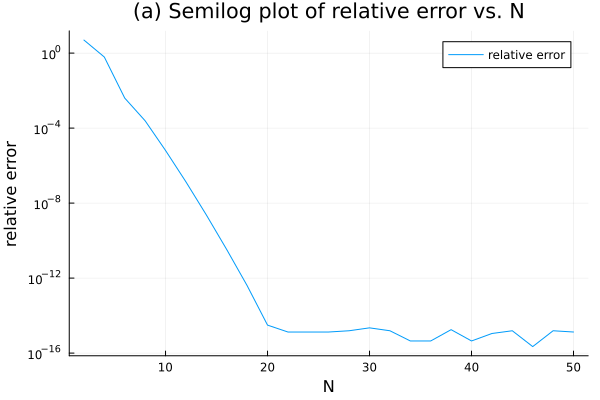

In [2]:
f_a(x) = 5cos(5x+5) # define f(x) function
N_list = 2:2:50 # list of number of points N: [2,4,...,50]
N_size = size(N_list, 1)
err_a = zeros(N_size) #Initialize the list of errors with the same size as N_list
for i=1:N_size
    N = N_list[i]
    x, w = clenshaw_curtis(N)
    err_a[i] = abs(sum(f_a.(x) .* w)/sin(10)-1)#relative error of the quadrature
end

using Plots
plot(N_list, err_a, yscale=:log10, yticks=[1,10^-4,10^-8,10^-12,10^-16],title = "(a) Semilog plot of relative error vs. N", label="relative error")
xlabel!("N")
ylabel!("relative error")

**(b)** Let $x = \frac{t + 1}{1-t}$, then $\int_0^{\infty} e^{-x} dx = \int_{-1}^{1} e^{-\frac{t + 1}{1-t}} \frac{2}{(1-t^2)}dt $. The relative errors are plotted below. $\log \varepsilon$ vs. $N$ decreases slower than a linear relation, but $\log \varepsilon$ vs. $\log N$ decreases faster than a linear relation, so the convergence rate is faster than a power law but slower than exponential. When we plot $\log \varepsilon$ vs. $\sqrt{N}$ on a semilog scale, we recover a linear relation, which suggests the true convergence rate is roughly $O(e^{-\sqrt{N}})$


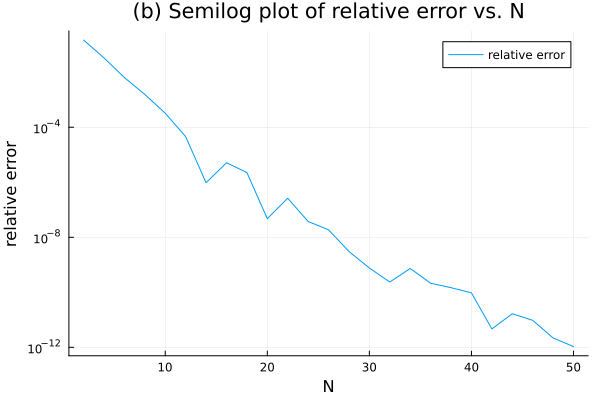

In [3]:
function f_b(x)
    if x == 1
        return 0
    else
        return 2exp(-(x+1)/(1-x))/(1-x)^2
    end
end


err_b = zeros(N_size) #Initialize the list of errors with the same size as N_list
for i=1:N_size
    N = N_list[i]
    x, w = clenshaw_curtis(N)
    err_b[i] = abs(sum(f_b.(x) .* w) - 1)#relative error of the quadrature
end


plot(N_list, err_b, yscale=:log10, yticks=[1,10^-4,10^-8,10^-12,10^-16],title = "(b) Semilog plot of relative error vs. N", label="relative error")
xlabel!("N")
ylabel!("relative error")

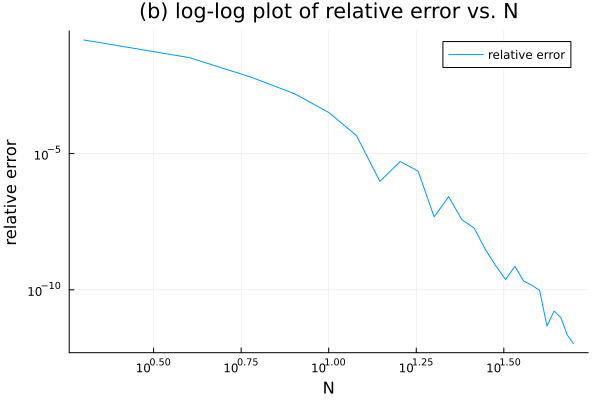

In [4]:
plot(N_list, err_b, xscale=:log10, yscale=:log10, title = "(b) log-log plot of relative error vs. N", label="relative error")
xlabel!("N")
ylabel!("relative error")

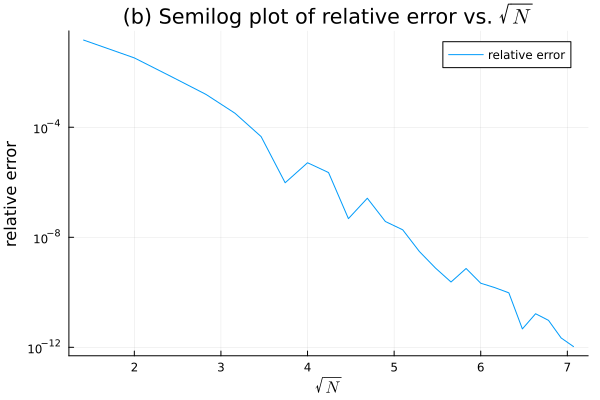

In [5]:
plot(sqrt.(N_list), err_b, yscale=:log10, yticks=[1,10^-4,10^-8,10^-12,10^-16],title = "(b) Semilog plot of relative error vs. \$ \\sqrt{N}\$", label="relative error")
xlabel!("\$\\sqrt{N}\$")
ylabel!("relative error")

**(c)** Polynomial of degree $N$ is completely determined by $N+1$ points. In other words, for any polynomial of degree $N$, interpolating a polynomial through any $N+1$ points would recover the original polynomial. To verify this, note that integration and quadrature rules are linear: if $\int_{-1}^{+1} f_1(x) dx = \sum_{n=0}^N w_n f_1(x_n)$ and $\int_{-1}^{+1} f_2(x) dx = \sum_{n=0}^N w_n f_2(x_n)$, then $\int_{-1}^{+1} (f_1(x)+kf_2(x)) dx = \sum_{n=0}^N w_n (f_1(x_n)+kf_2(x))$ for any real number $k$.

As a result, for $N=4$, it suffices to check the integral of any five linearly independent polynomials, e.g. $1, x, x^2, x^3, x^4$, for which the exact integral values are: 2, 0, 2/3, 0, 2/5. Quadrature results are checked below. The errors are within roundoff errors.


In [6]:
f_c = [x->1, x->x, x->x^2, x->x^3, x->x^4] #five polynomial functions to be checked
exact_results = [2, 0, 2/3, 0, 2/5]
err_c = zeros(5)
x_c, w_c = clenshaw_curtis(4)
for i=1:5
    f_ci = f_c[i]
    err_c[i] = sum(w_c .* f_ci.(x_c)) - exact_results[i]
end
err_c

5-element Vector{Float64}:
 -2.220446049250313e-16
  8.326672684688674e-17
  0.0
  1.3877787807814457e-16
  0.0

**(d)** The plot of error vs N is shown below. For any otherwise-smooth $f$ with single discontintuity at $x=0.5$, note that $f(|x|)$ is an even function, so $\int_{-1}^{1}f(x)dx = \int_{-1}^{0.5}f(x)dx + \int_{0.5}^{1}f(x)dx=\frac{3}{4}\int_{-1}^{1} f(3t/4-1/4)dt+\frac1{4}\int_{-1}^{1} f(t/4+3/4)dt$, so we can apply Clenshaw–Curtis to each interval separately. We plot the error vs N of the original and the new approaches below.


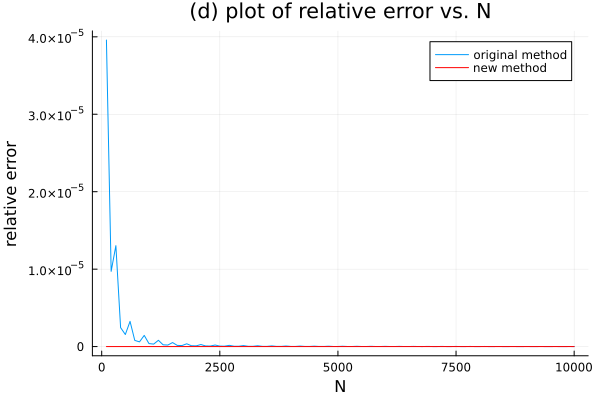

In [31]:
f_d_old(x) = sin(abs(x-0.5))
f_d_new(x) = 3/4 * f_d_old(3x/4-1/4) + 1/4 * f_d_old(x/4+3/4)

N_list = 100:100:10000
N_size = size(N_list, 1)

err_d_old = zeros(N_size)
err_d_new = zeros(N_size)
exact_d = 2sin(0.25)^2 + 2sin(0.75)^2

for i=1:N_size
    N = N_list[i]
    x, w = clenshaw_curtis(N)
    err_d_old[i] = abs(sum(f_d_old.(x) .* w)/exact_d - 1)
    err_d_new[i] = abs(sum(f_d_new.(x) .* w)/exact_d - 1)
end

plot(N_list, err_d_old, title = "(d) plot of relative error vs. N", label="original method")
plot!(N_list, err_d_new, c=:red, label="new method")
xlabel!("N")
ylabel!("relative error")

If we plot the error on log-log scale, we can see that for one order of magnitude increase of $N$, the error drops two orders of magnitude, so the convergence rate is roughly $O(1/N^2)$

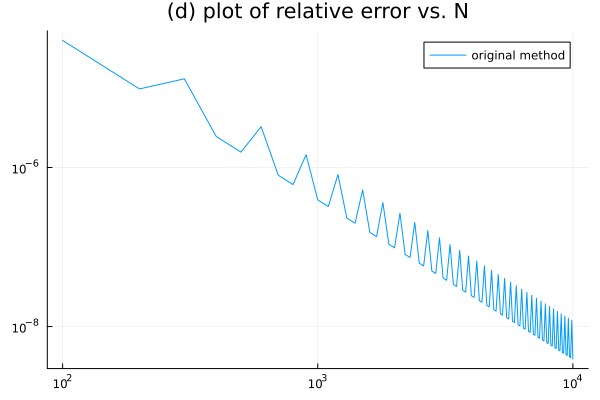

In [32]:
plot(N_list, err_d_old, yscale=:log10,xscale=:log10,title = "(d) plot of relative error vs. N", label="original method")